DESCRIPTIVE ANALYSIS

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('CustomerChurn.csv')

print(df.shape)
print(df.dtypes)
print(df.head(5))

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df.dropna(subset=['TotalCharges'], inplace=True)

print("\nMissing values per column:\n", df.isnull().sum())

(7043, 21)
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45    

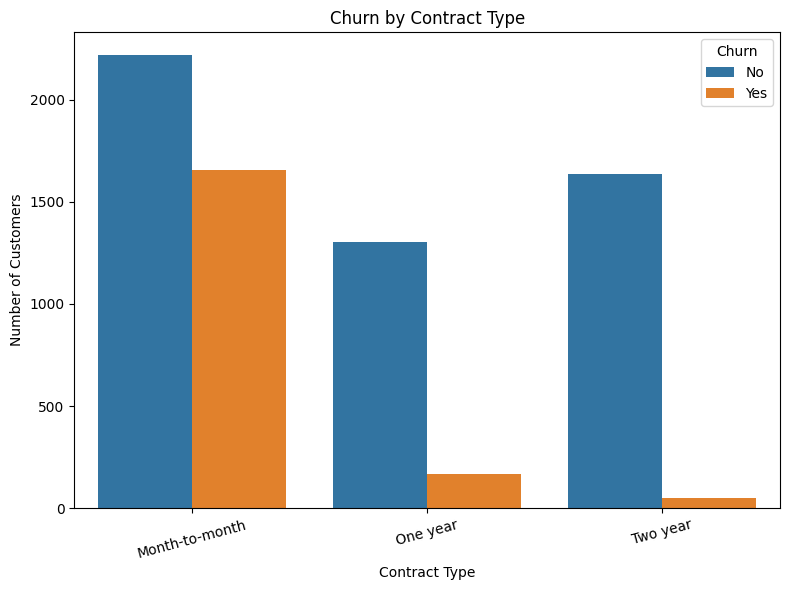


Churn distribution by contract type:
 Churn                 No       Yes
Contract                          
Month-to-month  0.572903  0.427097
One year        0.887228  0.112772
Two year        0.971513  0.028487


In [50]:
df = df.copy()

#We bin 'tenure' into segments
df['tenure_group'] = pd.cut(
    df['tenure'],
    bins = [0,12,24,48, df['tenure'].max()],
    labels = ['0-1 year', '1-2 years', '2-3 years', '4+ years']
)
#Bin MonthlyCharges into segments
df['MonthlyChargesGroup'] = pd.cut(
    df['MonthlyCharges'],
    bins = [0, 30, 60, 90, df['MonthlyCharges'].max()],
    labels = ['<$30', '$30-$60', '$60-$90', '>$90']
)

plt.figure(figsize=(8, 6))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

churn_distribution = df.groupby('Contract')['Churn'].value_counts(normalize=True).unstack()
print("\nChurn distribution by contract type:\n", churn_distribution)

PRESCRIPTIVE ANALYSIS

In [51]:
encoded_df = df.copy()
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in encoded_df.select_dtypes(include='object').columns:
    if col!= 'customerID':
        le = LabelEncoder()
        encoded_df[col] = le.fit_transform(encoded_df[col])
        label_encoders[col] = le

In [52]:
# Drop ID column
encoded_df = encoded_df.drop(columns=['customerID'])

# Keep only numeric columns
numeric_df = encoded_df.select_dtypes(include=[np.number])


correlation_with_churn = numeric_df.corr()['Churn'].sort_values(ascending=False)
print("\nCorrelation with Churn:\n", correlation_with_churn)



Correlation with Churn:
 Churn               1.000000
MonthlyCharges      0.192858
PaperlessBilling    0.191454
SeniorCitizen       0.150541
PaymentMethod       0.107852
MultipleLines       0.038043
PhoneService        0.011691
gender             -0.008545
StreamingTV        -0.036303
StreamingMovies    -0.038802
InternetService    -0.047097
Partner            -0.149982
Dependents         -0.163128
DeviceProtection   -0.177883
OnlineBackup       -0.195290
TotalCharges       -0.199484
TechSupport        -0.282232
OnlineSecurity     -0.289050
tenure             -0.354049
Contract           -0.396150
Name: Churn, dtype: float64


In [53]:
high_risk_customers = df[
    (df['tenure'] <= 12) &
    (df['MonthlyCharges'] >= 80) &
     (df['Contract'] == 'Month-to-month') &
    (df['PaymentMethod'] == 'Electronic check')
]

print(f"Number of high-risk customers found: {len(high_risk_customers)}\n")
print(high_risk_customers[['customerID', 'tenure', 'MonthlyCharges', 'Contract', 'PaymentMethod']].head())

Number of high-risk customers found: 329

     customerID  tenure  MonthlyCharges        Contract     PaymentMethod
5    9305-CDSKC       8           99.65  Month-to-month  Electronic check
47   7760-OYPDY       2           80.65  Month-to-month  Electronic check
64   5698-BQJOH       9           94.40  Month-to-month  Electronic check
115  3071-VBYPO       3           89.85  Month-to-month  Electronic check
117  5299-RULOA      10          100.25  Month-to-month  Electronic check


SIMULATED A/B TESTING

In [54]:
mtm_customers = df[df['Contract'] == 'Month-to-month'].copy()
mtm_customers['Simulated_Offer'] = 0

mtm_customers['Simulated_Offer'] = mtm_customers['MonthlyCharges'] > 70
mtm_customers['Simulated_Offer'] = mtm_customers['Simulated_Offer'].astype(int)


print(mtm_customers['Simulated_Offer'].value_counts())

Simulated_Offer
1    2097
0    1778
Name: count, dtype: int64


In [55]:
churn_rates = mtm_customers.groupby('Simulated_Offer')['Churn'].value_counts(normalize=True).unstack()
print("\nChurn Rate (Control vs Treatment):\n", churn_rates)


Churn Rate (Control vs Treatment):
 Churn                  No       Yes
Simulated_Offer                    
0                0.690664  0.309336
1                0.473057  0.526943


In [56]:
retained = mtm_customers[(mtm_customers['Simulated_Offer'] == 1) & (mtm_customers['Churn'] == "No")]
revenue_saved = retained['MonthlyCharges'].sum()

offer_cost = len(retained) * 10

print(f"\nRevenue Saved: ${revenue_saved:.2f}")
print(f"Cost of Offer: ${offer_cost:.2f}")
print(f"Net Benefit: ${revenue_saved - offer_cost:.2f}")



Revenue Saved: $86948.00
Cost of Offer: $9920.00
Net Benefit: $77028.00


In [57]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(mtm_customers['Simulated_Offer'], mtm_customers['Churn'])

chi2, p, dof, expected = chi2_contingency(contingency)
print("\nChi-Square Test:")
print(f"Chi2 = {chi2:.4f}, p-value = {p:.4f}")

if p<0.5:
    print("Difference in churn rates is statistically significant.")
else:
    print("No statistically significant difference in churn rates.")



Chi-Square Test:
Chi2 = 185.3189, p-value = 0.0000
Difference in churn rates is statistically significant.


In [58]:
control_group = mtm_customers[mtm_customers['Simulated_Offer'] == 0]
treatment_group = mtm_customers[mtm_customers['Simulated_Offer'] == 1]

control_churn_rate = control_group['Churn'].value_counts(normalize=True).get('Yes', 0)
treatment_churn_rate = treatment_group['Churn'].value_counts(normalize=True).get('Yes', 0)

churn_rate_reduction = control_churn_rate - treatment_churn_rate

customers_saved = churn_rate_reduction * len(treatment_group)

avg_monthly_charge = treatment_group['MonthlyCharges'].mean()
revenue_saved = customers_saved * avg_monthly_charge * 6

offer_cost_per_customer = 10*6
offer_cost = len(treatment_group) * offer_cost_per_customer

net_benefit = revenue_saved - offer_cost

print(f"Control Churn Rate: {control_churn_rate:.2%}")
print(f"Treatment Churn Rate: {treatment_churn_rate:.2%}")
print(f"Churn Rate Reduction: {churn_rate_reduction:.2%}")
print(f"Estimated Customers Saved: {customers_saved:.0f}")
print(f"Average Monthly Charge: ${avg_monthly_charge:.2f}")
print(f"Estimated Revenue Saved (6 months): ${revenue_saved:,.2f}")
print(f"Total Offer Cost: ${offer_cost:,.2f}")
print(f"Net Benefit of Offer: ${net_benefit:,.2f}")

Control Churn Rate: 30.93%
Treatment Churn Rate: 52.69%
Churn Rate Reduction: -21.76%
Estimated Customers Saved: -456
Average Monthly Charge: $87.52
Estimated Revenue Saved (6 months): $-239,617.60
Total Offer Cost: $125,820.00
Net Benefit of Offer: $-365,437.60


TIME SERIES ANALYSIS

In [59]:
import sys
!{sys.executable} -m pip install pmdarima


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [60]:
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA


# Simulate join month based on tenure in days (assuming dataset is from Jan 2020)
df['JoinMonth'] = pd.to_datetime((df['tenure'] * 30), unit='D', origin='2020-01-01')

# Calculate churn rate per month
monthly_churn = df.groupby(df['JoinMonth'].dt.to_period('M'))['Churn'].apply(lambda x: (x == 'Yes').mean())

# Convert period to timestamp for plotting
monthly_churn.index = monthly_churn.index.to_timestamp()



 ADF Test 
ADF Statistic: -1.9125
p-value: 0.3262
Series is non-stationary.
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-214.745, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-213.849, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-215.649, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-221.315, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-213.763, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-221.601, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-221.070, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-221.266, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-222.962, Time=0.36 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-221.507, Time=0.37 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-219.353, Time=0.70 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-217.378, Time=0.16 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 4.768 seconds

 Autp ARIM

c:\Users\its_b\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\its_b\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\its_b\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\its_b\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is ava

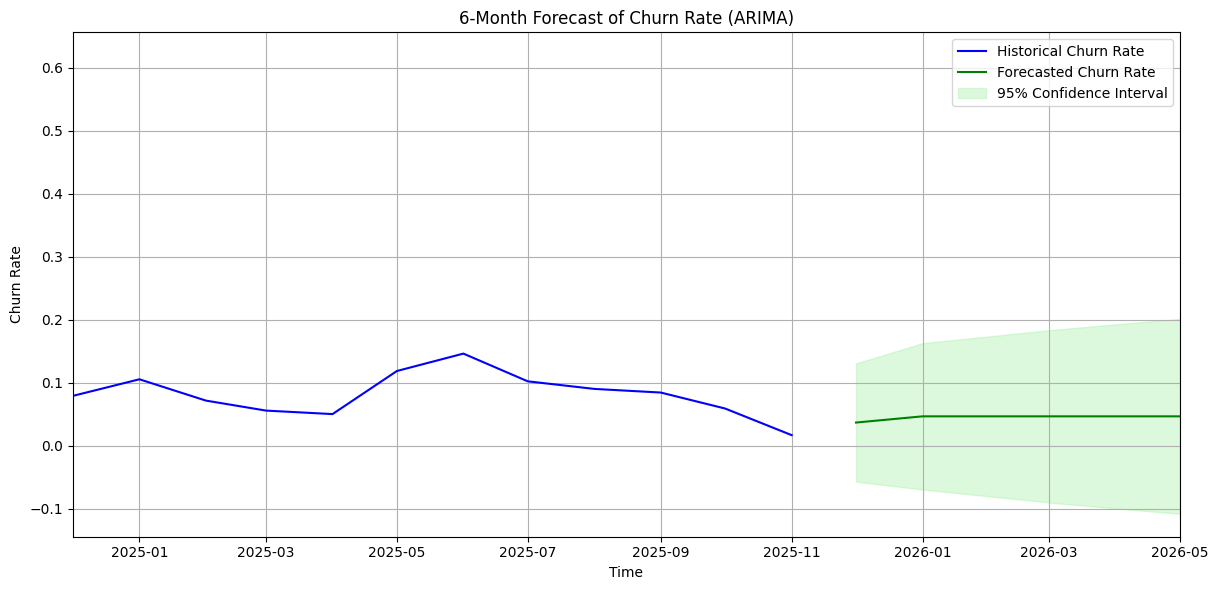

In [ ]:
print("\n ADF Test ")
adf_result = adfuller(monthly_churn)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
if adf_result[1] > 0.05:
    print("Series is non-stationary.")
else: 
    print("Series is stationary. Proceed with ARIMA")


stepwise_model = auto_arima(monthly_churn,
                            seasonal=False,
                            trace=True,
                            suppress_warnings=True,
                            error_action="ignore")

print("\n Autp ARIMA Summary ")
print(stepwise_model.summary())


model = ARIMA(monthly_churn, order=stepwise_model.order)
model_fit = model.fit()

forecast_result = model_fit.get_forecast(steps=6)
forecast = forecast_result.predicted_mean

# Align forecast index with future months
last_date = monthly_churn.index[-1]
forecast.index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=6, freq='MS')

conf_int = forecast_result.conf_int()
conf_int.index = forecast.index


plt.figure(figsize=(12,6))
plt.plot(monthly_churn, label='Historical Churn Rate', color='blue')
plt.plot(forecast.index, forecast, label='Forecasted Churn Rate', color='green')

# Plotting confidence interval using correct column names
plt.fill_between(forecast.index,
                 conf_int['lower Churn'],
                 conf_int['upper Churn'],
                 color='lightgreen', alpha=0.3, label='95% Confidence Interval')

plt.title('6-Month Forecast of Churn Rate (ARIMA)')
plt.xlabel('Time')
plt.ylabel('Churn Rate')
plt.legend()
plt.tight_layout()
plt.grid(True)
# Optional: Zoom in to the last 12 months + forecast
visible_start = monthly_churn.index[-12]  # 12 months back
visible_end = forecast.index[-1]         # last forecasted date
plt.xlim([visible_start, visible_end])

plt.show()

#"Based on the ARIMA forecast, the churn rate is expected to remain relatively stable over the next 6 months with minor fluctuations. The absence of sharp increases suggests no immediate churn crisis. However, proactive retention strategies should continue to minimize risk."

In [62]:
print("Monthly Churn Data:")
print(monthly_churn.head())
print("\nIndex Type:", type(monthly_churn.index))
print("Is Datetime Index:", isinstance(monthly_churn.index, pd.DatetimeIndex))


Monthly Churn Data:
JoinMonth
2020-01-01    0.619902
2020-03-01    0.495434
2020-04-01    0.471591
2020-05-01    0.481203
2020-06-01    0.363636
Name: Churn, dtype: float64

Index Type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Is Datetime Index: True
